| Parameter    | Units                 | Physical Role                                        |
|--------------|-----------------------|------------------------------------------------------|
| $$ \mu $$    | Pa·s                  | Dynamic viscosity of blood                           |
| $$ k_t $$    | $$ \text{m}^2 $$      | 3D tissue permeability                               |
| $$ k_v $$    | $$ \text{m}^2 $$      | Axial permeability along the vessel                  |
| $$ \gamma $$ | $$ \text{m}/(\text{Pa}\cdot\text{s}) $$ | Vessel wall permeability coefficient (coupling tissue & vessel) |
| $$ \gamma_R $$ | $$ \text{m}/(\text{Pa}\cdot\text{s}) $$ | Boundary outflow (Robin) permeability                 |
| $$ \gamma_a $$ | m                    | Terminal vessel coupling length scale (hydraulic conductance at end) |

In [5]:
!pip install numpy==1.26.4
!pip install ipywidgets vtk meshio pyvista Rtree

In [6]:
WORK_MOUNT_PATH = "/root/3d-1d"

import sys, os
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import importlib

sys.path.append(os.path.join(WORK_MOUNT_PATH, 'modules'))

In [7]:
import GraphUtility
importlib.reload(GraphUtility)

TEST_GRAPH_NODES = {
    0: [0.000, 0.020, 0.015],   # A
    1: [0.010, 0.020, 0.015],   # B
    2: [0.022, 0.013, 0.015],   # C
    3: [0.022, 0.028, 0.015],   # D
    4: [0.015, 0.005, 0.015],   # E
    5: [0.015, 0.035, 0.015],   # F
    6: [0.038, 0.005, 0.015],   # G
    7: [0.038, 0.035, 0.015]    # H
}

TEST_GRAPH_EDGES = [
    (0, 1, 0.004),  # AB
    (1, 2, 0.003),  # BC
    (1, 3, 0.003),  # BD
    (2, 4, 0.002),  # CE
    (2, 6, 0.003),  # CG
    (3, 5, 0.002),  # DF
    (3, 7, 0.003)   # DH
]

diag_path = [0, 1, 2, 6]
try:
    G, original_to_new, edge_to_new_nodes = GraphUtility.build_graph(TEST_GRAPH_NODES, TEST_GRAPH_EDGES, 10)
    intermediate_nodes = GraphUtility.get_new_nodes_along_path(diag_path, edge_to_new_nodes)
    print("New (intermediate) nodes along the path:", intermediate_nodes)
except ValueError as e:
    print("Invalid path:", e)

New (intermediate) nodes along the path: [8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57]


In [8]:
import FEMSinkVelo
importlib.reload(FEMSinkVelo)

<module 'FEMSinkVelo' from '/root/3d-1d/modules/FEMSinkVelo.py'>

In [9]:
import FEMSink2
importlib.reload(FEMSink2)

<module 'FEMSink2' from '/root/3d-1d/modules/FEMSink2.py'>

In [10]:
fem_test = FEMSinkVelo.FEMSinkVelo(
    G=G,
    gamma = 1.45e8,
    gamma_R = 1300,
    gamma_v = 25,
    gamma_a = 2,
    mu = 1.0e-3, # Viscosity
    k_t = 1.0e-10, # Tissue permeability in 3D
    k_v = 1.5e-11, # Vessel permeability in 1D
    P_in = 100.0 * 133.322, # 100 mmHg
    p_cvp = 1.0 * 133.322, # 1 mmHg
    Lambda_inlet = [0],
    Lambda_padding_min = 0.008
)

Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.


Averaging over 154 cells: 100%|██████████| 154/154 [00:00<00:00, 2525.07it/s]

Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.


Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FF

In [11]:
print(fem_test.compute_inflow_inlet())

7.935253019215513e-06


In [12]:
import Visualizer
importlib.reload(Visualizer)

<module 'Visualizer' from '/root/3d-1d/modules/Visualizer.py'>

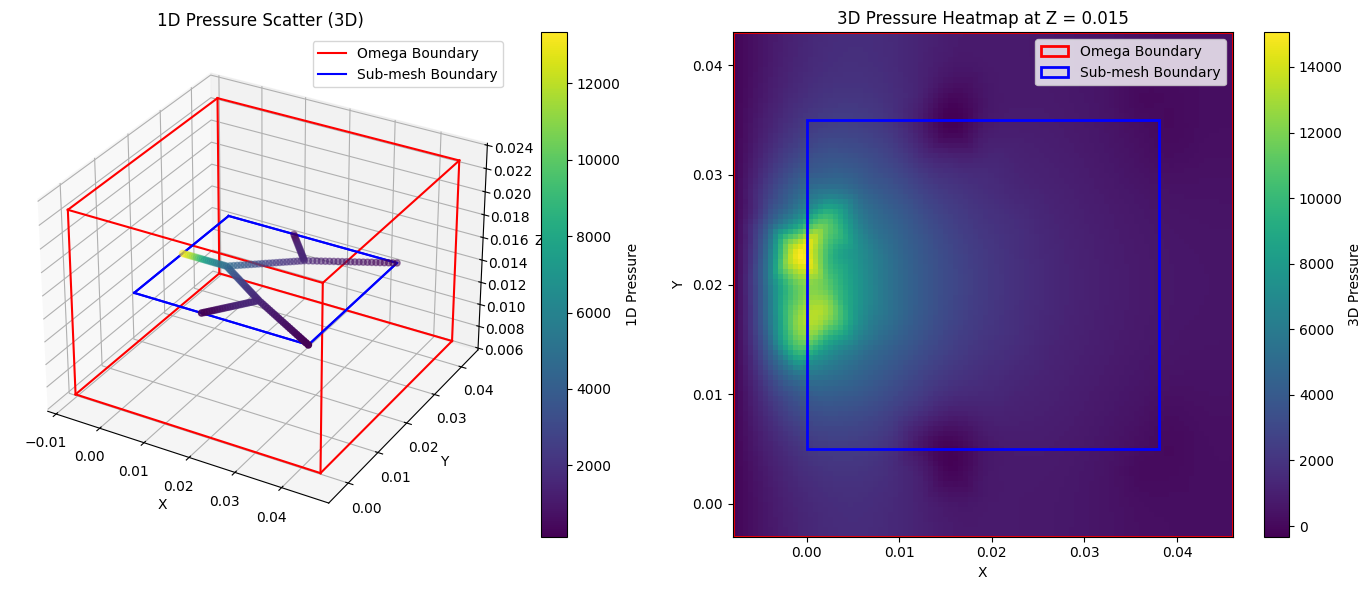

In [13]:
Visualizer.plot_with_boundaries(fem_test.uh1d, fem_test.uh3d)

Node Pressure Data:
Node 8: Pressure 12723.8
Node 9: Pressure 11979.3
Node 10: Pressure 10867.2
Node 11: Pressure 9579.6
Node 12: Pressure 8411.9
Node 13: Pressure 7415.9
Node 14: Pressure 6805.5
Node 15: Pressure 6291.5
Node 16: Pressure 5724.1
Node 17: Pressure 5215.7
Node 18: Pressure 4363.4
Node 19: Pressure 3942.7
Node 20: Pressure 3549.1
Node 21: Pressure 3183.7
Node 22: Pressure 2869.2
Node 23: Pressure 2573.9
Node 24: Pressure 2301.5
Node 25: Pressure 2061.1
Node 26: Pressure 1865.2
Node 27: Pressure 1726.8
Node 48: Pressure 1361.0
Node 49: Pressure 1198.2
Node 50: Pressure 1078.7
Node 51: Pressure 969.3
Node 52: Pressure 863.5
Node 53: Pressure 761.1
Node 54: Pressure 656.1
Node 55: Pressure 547.7
Node 56: Pressure 419.4
Node 57: Pressure 258.7


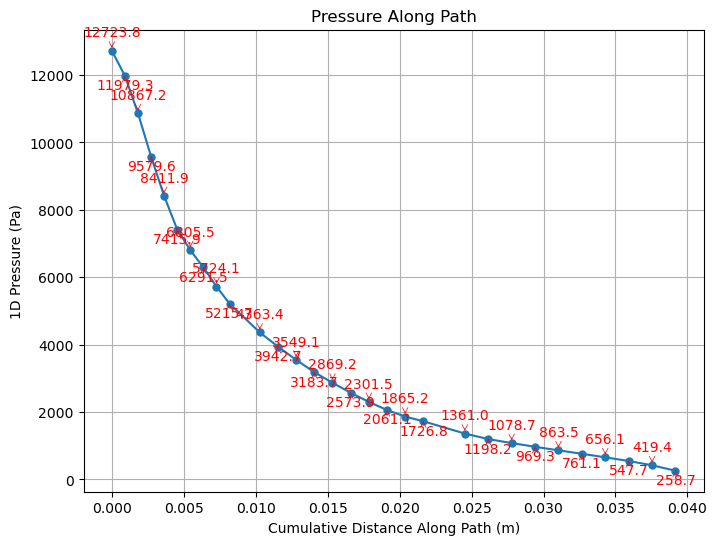

In [12]:
Visualizer.plot_path_pressure(fem_test.uh1d, intermediate_nodes)

In [26]:
import FEMSinkCubeFlux
importlib.reload(FEMSinkCubeFlux)

<module 'FEMSinkCubeFlux' from '/home/jovyan/work/3d-1d/modules/FEMSinkCubeFlux.py'>

In [27]:
fem_test_2 = FEMSinkCubeFlux.FEMSinkCubeFlux(
    G=G,
    gamma = 1.45e8,
    gamma_R = 1300,
    gamma_v = 25,
    gamma_a = 2,
    mu = 1.0e-3, # Viscosity
    k_t = 1.0e-10, # Tissue permeability in 3D
    k_v = 1.5e-11, # Vessel permeability in 1D
    P_in = 100.0 * 133.322, # 100 mmHg
    p_cvp = 1.0 * 133.322, # 1 mmHg
    Lambda_inlet = [0],
    Lambda_padding_min = 0.008
)

Averaging over 154 cells: 100%|██████████| 154/154 [00:00<00:00, 2068.92it/s]


Applied BC! Non-empty list


Lower Cube Bounds: (-0.008, -0.0064, -0.003, -0.0014, 0.006999999999999999, 0.0086)
Upper Cube Bounds: (0.0444, 0.046, 0.0414, 0.043, 0.0214, 0.023)


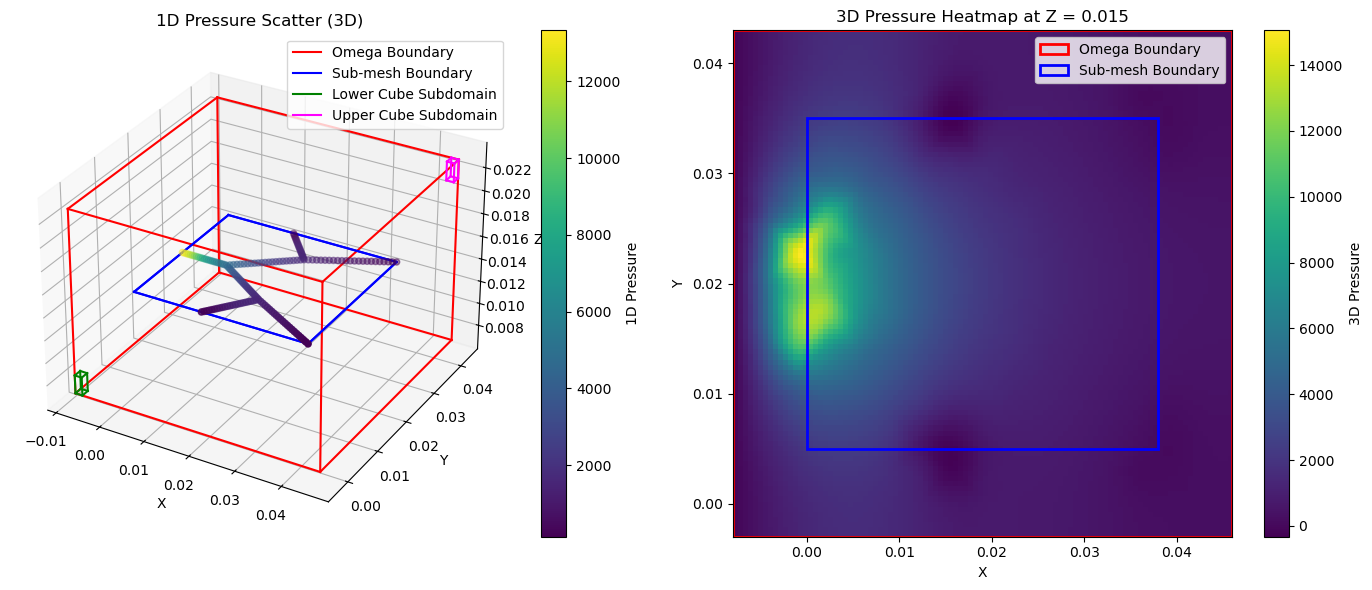

In [36]:
cube_lower_bounds = fem_test_2.lower_cube_bounds
cube_upper_bounds = fem_test_2.upper_cube_bounds

print("Lower Cube Bounds:", cube_lower_bounds)
print("Upper Cube Bounds:", cube_upper_bounds)

Visualizer.plot_with_boundaries(fem_test_2.uh1d, fem_test_2.uh3d,
     cube_lower=cube_lower_bounds, 
     cube_upper=cube_upper_bounds)

In [29]:
fem_test_2.compute_upper_cube_flux()

0.0

Averaging over 154 cells: 100%|██████████| 154/154 [00:00<00:00, 2262.13it/s]


Applied BC! Non-empty list
    Calling FFC just-in-time (JIT) compiler, this may take some time.


Averaging over 154 cells: 100%|██████████| 154/154 [00:00<00:00, 2190.60it/s]


Applied BC! Non-empty list


Averaging over 154 cells: 100%|██████████| 154/154 [00:00<00:00, 2156.10it/s]


Applied BC! Non-empty list


Averaging over 154 cells: 100%|██████████| 154/154 [00:00<00:00, 2280.57it/s]


Applied BC! Non-empty list


Averaging over 154 cells: 100%|██████████| 154/154 [00:00<00:00, 2342.74it/s]


Applied BC! Non-empty list


Averaging over 154 cells: 100%|██████████| 154/154 [00:00<00:00, 2341.73it/s]


Applied BC! Non-empty list


Averaging over 154 cells: 100%|██████████| 154/154 [00:00<00:00, 2374.52it/s]


Applied BC! Non-empty list


Averaging over 154 cells: 100%|██████████| 154/154 [00:00<00:00, 2156.38it/s]


Applied BC! Non-empty list


Averaging over 154 cells: 100%|██████████| 154/154 [00:00<00:00, 2205.36it/s]


Applied BC! Non-empty list
Iteration 1: parameters (log scale) = [-0.2    0.06   0.06   0.06  -7.994], cost = 3.1662565036126074e-09


Averaging over 154 cells: 100%|██████████| 154/154 [00:00<00:00, 2293.69it/s]


Applied BC! Non-empty list


Averaging over 154 cells: 100%|██████████| 154/154 [00:00<00:00, 2305.71it/s]


Applied BC! Non-empty list
Iteration 2: parameters (log scale) = [-0.2    0.06   0.06   0.06  -7.994], cost = 3.1662565036126074e-09


Averaging over 154 cells: 100%|██████████| 154/154 [00:00<00:00, 2296.77it/s]


Applied BC! Non-empty list


Averaging over 154 cells: 100%|██████████| 154/154 [00:00<00:00, 2357.70it/s]


Applied BC! Non-empty list
Iteration 3: parameters (log scale) = [-0.2    0.06   0.06   0.06  -7.994], cost = 3.1662565036126074e-09


Averaging over 154 cells: 100%|██████████| 154/154 [00:00<00:00, 2293.05it/s]


Applied BC! Non-empty list


Averaging over 154 cells: 100%|██████████| 154/154 [00:00<00:00, 2391.98it/s]


Applied BC! Non-empty list
Iteration 4: parameters (log scale) = [-0.2    0.06   0.06   0.06  -7.994], cost = 3.1662565036126074e-09


Averaging over 154 cells: 100%|██████████| 154/154 [00:00<00:00, 2323.49it/s]


Applied BC! Non-empty list


Averaging over 154 cells: 100%|██████████| 154/154 [00:00<00:00, 2161.32it/s]


Applied BC! Non-empty list


Averaging over 154 cells: 100%|██████████| 154/154 [00:00<00:00, 2395.41it/s]


Applied BC! Non-empty list
Iteration 5: parameters (log scale) = [-0.32928    0.061824   0.263424   0.119424  -8.0018816], cost = 3.162395019538077e-09


Averaging over 154 cells: 100%|██████████| 154/154 [00:00<00:00, 2392.37it/s]


Applied BC! Non-empty list


Averaging over 154 cells: 100%|██████████| 154/154 [00:00<00:00, 2322.46it/s]


Applied BC! Non-empty list


Averaging over 154 cells: 100%|██████████| 154/154 [00:00<00:00, 2416.31it/s]


Applied BC! Non-empty list
Iteration 6: parameters (log scale) = [-0.526848    0.0989184   0.1614784   0.1910784  -8.00301056], cost = 3.1564876861304776e-09


Averaging over 154 cells: 100%|██████████| 154/154 [00:00<00:00, 2317.61it/s]


Applied BC! Non-empty list


Averaging over 154 cells: 100%|██████████| 154/154 [00:00<00:00, 2341.89it/s]


Applied BC! Non-empty list
Iteration 7: parameters (log scale) = [-0.526848    0.0989184   0.1614784   0.1910784  -8.00301056], cost = 3.1564876861304776e-09


Averaging over 154 cells: 100%|██████████| 154/154 [00:00<00:00, 2307.16it/s]


Applied BC! Non-empty list


Averaging over 154 cells: 100%|██████████| 154/154 [00:00<00:00, 2310.47it/s]


Applied BC! Non-empty list


Averaging over 154 cells: 100%|██████████| 154/154 [00:00<00:00, 2243.71it/s]


Applied BC! Non-empty list
Iteration 8: parameters (log scale) = [-0.77373952  0.26045722  0.31659162  0.10289562 -7.99413565], cost = 3.1479446723695206e-09


Averaging over 154 cells: 100%|██████████| 154/154 [00:00<00:00, 2283.45it/s]


Applied BC! Non-empty list


Averaging over 154 cells: 100%|██████████| 154/154 [00:00<00:00, 2419.92it/s]


Applied BC! Non-empty list
Iteration 9: parameters (log scale) = [-0.77373952  0.26045722  0.31659162  0.10289562 -7.99413565], cost = 3.1479446723695206e-09


Averaging over 154 cells: 100%|██████████| 154/154 [00:00<00:00, 2416.75it/s]


Applied BC! Non-empty list


Averaging over 154 cells: 100%|██████████| 154/154 [00:00<00:00, 2380.39it/s]


Applied BC! Non-empty list


Averaging over 154 cells: 100%|██████████| 154/154 [00:00<00:00, 2334.33it/s]


Applied BC! Non-empty list
Iteration 10: parameters (log scale) = [-1.30098452  0.24391056  0.62341162  0.34633258 -8.00296563], cost = 3.1140125866669165e-09


Averaging over 154 cells: 100%|██████████| 154/154 [00:00<00:00, 2318.69it/s]


Applied BC! Non-empty list


Averaging over 154 cells: 100%|██████████| 154/154 [00:00<00:00, 2232.52it/s]


Applied BC! Non-empty list
Iteration 11: parameters (log scale) = [-1.30098452  0.24391056  0.62341162  0.34633258 -8.00296563], cost = 3.1140125866669165e-09


Averaging over 154 cells: 100%|██████████| 154/154 [00:00<00:00, 2207.48it/s]


Applied BC! Non-empty list


Averaging over 154 cells: 100%|██████████| 154/154 [00:00<00:00, 2224.01it/s]


Applied BC! Non-empty list


Averaging over 154 cells: 100%|██████████| 154/154 [00:00<00:00, 2291.73it/s]


Applied BC! Non-empty list
Iteration 12: parameters (log scale) = [-1.83011702  0.58395941  0.62357137  0.47485032 -8.00644821], cost = 3.047912828179021e-09


Averaging over 154 cells: 100%|██████████| 154/154 [00:00<00:00, 2301.70it/s]


Applied BC! Non-empty list


Averaging over 154 cells: 100%|██████████| 154/154 [00:00<00:00, 2345.39it/s]


Applied BC! Non-empty list
Iteration 13: parameters (log scale) = [-1.83011702  0.58395941  0.62357137  0.47485032 -8.00644821], cost = 3.047912828179021e-09


Averaging over 154 cells: 100%|██████████| 154/154 [00:00<00:00, 1831.03it/s]


Applied BC! Non-empty list


Averaging over 154 cells: 100%|██████████| 154/154 [00:00<00:00, 2313.08it/s]


Applied BC! Non-empty list


Averaging over 154 cells: 100%|██████████| 154/154 [00:00<00:00, 2017.70it/s]


Applied BC! Non-empty list
Iteration 14: parameters (log scale) = [-2.63736809  0.76972978  1.03698065  0.45934374 -8.00661489], cost = 2.8006241473084948e-09


Averaging over 154 cells: 100%|██████████| 154/154 [00:00<00:00, 2086.59it/s]


Applied BC! Non-empty list


Averaging over 154 cells: 100%|██████████| 154/154 [00:00<00:00, 2008.10it/s]


Applied BC! Non-empty list


Averaging over 154 cells: 100%|██████████| 154/154 [00:00<00:00, 1829.49it/s]


Applied BC! Non-empty list
Iteration 15: parameters (log scale) = [-3.71833716  0.89318895  1.39912762  0.96663336 -8.01251838], cost = 2.0137579333539564e-09


Averaging over 154 cells: 100%|██████████| 154/154 [00:00<00:00, 2011.99it/s]


Applied BC! Non-empty list


Averaging over 154 cells: 100%|██████████| 154/154 [00:00<00:00, 1785.30it/s]


Applied BC! Non-empty list
Iteration 16: parameters (log scale) = [-3.71833716  0.89318895  1.39912762  0.96663336 -8.01251838], cost = 2.0137579333539564e-09


Averaging over 154 cells: 100%|██████████| 154/154 [00:00<00:00, 1993.07it/s]


Applied BC! Non-empty list


Averaging over 154 cells: 100%|██████████| 154/154 [00:00<00:00, 1890.57it/s]


Applied BC! Non-empty list


Averaging over 154 cells: 100%|██████████| 154/154 [00:00<00:00, 2025.78it/s]


Applied BC! Non-empty list
Iteration 17: parameters (log scale) = [-5.39450238  1.73064656  1.85793472  1.14649369 -8.01466847], cost = 3.1276666174683925e-10


Averaging over 154 cells: 100%|██████████| 154/154 [00:00<00:00, 2028.66it/s]


Applied BC! Non-empty list


Averaging over 154 cells: 100%|██████████| 154/154 [00:00<00:00, 1933.07it/s]


Applied BC! Non-empty list
Iteration 18: parameters (log scale) = [-5.39450238  1.73064656  1.85793472  1.14649369 -8.01466847], cost = 3.1276666174683925e-10


Averaging over 154 cells: 100%|██████████| 154/154 [00:00<00:00, 1980.25it/s]


Applied BC! Non-empty list


Averaging over 154 cells: 100%|██████████| 154/154 [00:00<00:00, 1927.12it/s]


Applied BC! Non-empty list


Averaging over 154 cells: 100%|██████████| 154/154 [00:00<00:00, 1914.62it/s]


Applied BC! Non-empty list
Iteration 19: parameters (log scale) = [-8.3552589   2.31320837  3.2390998   1.73981365 -8.03482379], cost = 2.5344723478637566e-11


Averaging over 154 cells: 100%|██████████| 154/154 [00:00<00:00, 1907.26it/s]


Applied BC! Non-empty list


Averaging over 154 cells: 100%|██████████| 154/154 [00:00<00:00, 2085.25it/s]


Applied BC! Non-empty list
Iteration 20: parameters (log scale) = [-8.3552589   2.31320837  3.2390998   1.73981365 -8.03482379], cost = 2.5344723478637566e-11


Averaging over 154 cells: 100%|██████████| 154/154 [00:00<00:00, 1988.68it/s]


Applied BC! Non-empty list


Averaging over 154 cells: 100%|██████████| 154/154 [00:00<00:00, 1925.58it/s]


Applied BC! Non-empty list


Averaging over 154 cells: 100%|██████████| 154/154 [00:00<00:00, 2063.16it/s]


Applied BC! Non-empty list
Iteration 21: parameters (log scale) = [-11.39175716   3.25140145   3.89985721   2.55511643  -8.04495286], cost = 2.500031650164774e-11


Averaging over 154 cells: 100%|██████████| 154/154 [00:00<00:00, 1969.79it/s]


Applied BC! Non-empty list


Averaging over 154 cells: 100%|██████████| 154/154 [00:00<00:00, 1944.68it/s]


Applied BC! Non-empty list
Iteration 22: parameters (log scale) = [-11.39175716   3.25140145   3.89985721   2.55511643  -8.04495286], cost = 2.500031650164774e-11


Averaging over 154 cells: 100%|██████████| 154/154 [00:00<00:00, 1836.14it/s]


Applied BC! Non-empty list


Averaging over 154 cells: 100%|██████████| 154/154 [00:00<00:00, 2004.79it/s]


Applied BC! Non-empty list


Averaging over 154 cells: 100%|██████████| 154/154 [00:00<00:00, 1965.56it/s]


Applied BC! Non-empty list
Iteration 23: parameters (log scale) = [-16.61304127   4.83804324   5.93958682   3.54038517  -8.05012746], cost = 2.5000000001901043e-11


Averaging over 154 cells: 100%|██████████| 154/154 [00:00<00:00, 1993.69it/s]


Applied BC! Non-empty list


Averaging over 154 cells: 100%|██████████| 154/154 [00:00<00:00, 1947.19it/s]


Applied BC! Non-empty list


Averaging over 154 cells: 100%|██████████| 154/154 [00:00<00:00, 1938.01it/s]


Applied BC! Non-empty list
Iteration 24: parameters (log scale) = [-22.45212584   6.16792194   8.2630152    4.95753714  -8.10154367], cost = 2.4999999999999607e-11


Averaging over 154 cells: 100%|██████████| 154/154 [00:00<00:00, 2006.61it/s]


Applied BC! Non-empty list


Averaging over 154 cells: 100%|██████████| 154/154 [00:00<00:00, 2002.04it/s]


Applied BC! Non-empty list
Iteration 25: parameters (log scale) = [-22.45212584   6.16792194   8.2630152    4.95753714  -8.10154367], cost = 2.4999999999999607e-11


Averaging over 154 cells: 100%|██████████| 154/154 [00:00<00:00, 1936.79it/s]


Applied BC! Non-empty list


Averaging over 154 cells: 100%|██████████| 154/154 [00:00<00:00, 2019.90it/s]


Applied BC! Non-empty list
Iteration 26: parameters (log scale) = [-22.45212584   6.16792194   8.2630152    4.95753714  -8.10154367], cost = 2.4999999999999607e-11


Averaging over 154 cells: 100%|██████████| 154/154 [00:00<00:00, 1971.25it/s]


Applied BC! Non-empty list


Averaging over 154 cells: 100%|██████████| 154/154 [00:00<00:00, 1904.75it/s]


Applied BC! Non-empty list
Iteration 27: parameters (log scale) = [-22.45212584   6.16792194   8.2630152    4.95753714  -8.10154367], cost = 2.4999999999999607e-11


Averaging over 154 cells: 100%|██████████| 154/154 [00:00<00:00, 2014.23it/s]


Applied BC! Non-empty list


Averaging over 154 cells: 100%|██████████| 154/154 [00:00<00:00, 2036.73it/s]


Applied BC! Non-empty list


Averaging over 154 cells: 100%|██████████| 154/154 [00:00<00:00, 1950.63it/s]


Applied BC! Non-empty list
Iteration 28: parameters (log scale) = [-43.70649536  12.33245095  15.96973083   9.23664828  -8.16175121], cost = 2.499999999999957e-11


Averaging over 154 cells: 100%|██████████| 154/154 [00:00<00:00, 1969.59it/s]


Applied BC! Non-empty list


Averaging over 154 cells: 100%|██████████| 154/154 [00:00<00:00, 2011.75it/s]


Applied BC! Non-empty list
Iteration 29: parameters (log scale) = [-43.70649536  12.33245095  15.96973083   9.23664828  -8.16175121], cost = 2.499999999999957e-11


Averaging over 154 cells: 100%|██████████| 154/154 [00:00<00:00, 2040.42it/s]


Applied BC! Non-empty list


Averaging over 154 cells: 100%|██████████| 154/154 [00:00<00:00, 1856.45it/s]


Applied BC! Non-empty list


Averaging over 154 cells: 100%|██████████| 154/154 [00:00<00:00, 1903.71it/s]


Applied BC! Non-empty list
Iteration 30: parameters (log scale) = [-43.70649536  12.33245095  15.96973083   9.23664828  -8.16175121], cost = 2.499999999999957e-11


Averaging over 154 cells: 100%|██████████| 154/154 [00:00<00:00, 2002.02it/s]


Applied BC! Non-empty list


Averaging over 154 cells: 100%|██████████| 154/154 [00:00<00:00, 1905.07it/s]


Applied BC! Non-empty list


Averaging over 154 cells: 100%|██████████| 154/154 [00:00<00:00, 1947.49it/s]


Applied BC! Non-empty list


Averaging over 154 cells: 100%|██████████| 154/154 [00:00<00:00, 2065.44it/s]


Applied BC! Non-empty list


Averaging over 154 cells: 100%|██████████| 154/154 [00:00<00:00, 1989.95it/s]


Applied BC! Non-empty list


Averaging over 154 cells: 100%|██████████| 154/154 [00:00<00:00, 1981.74it/s]


Applied BC! Non-empty list


Averaging over 154 cells: 100%|██████████| 154/154 [00:00<00:00, 1970.89it/s]


Applied BC! Non-empty list


Averaging over 154 cells: 100%|██████████| 154/154 [00:00<00:00, 1998.47it/s]


Applied BC! Non-empty list
Iteration 31: parameters (log scale) = [-43.70649536  12.33245095  15.96973083   9.23664828  -8.16175121], cost = 2.499999999999957e-11


Averaging over 154 cells: 100%|██████████| 154/154 [00:00<00:00, 1944.54it/s]


Applied BC! Non-empty list


Averaging over 154 cells: 100%|██████████| 154/154 [00:00<00:00, 2013.51it/s]


Applied BC! Non-empty list


Averaging over 154 cells: 100%|██████████| 154/154 [00:00<00:00, 1998.19it/s]


Applied BC! Non-empty list
Iteration 32: parameters (log scale) = [-43.70649536  12.33245095  15.96973083   9.23664828  -8.16175121], cost = 2.499999999999957e-11


Averaging over 154 cells: 100%|██████████| 154/154 [00:00<00:00, 1965.07it/s]


Applied BC! Non-empty list


Averaging over 154 cells: 100%|██████████| 154/154 [00:00<00:00, 2062.18it/s]


Applied BC! Non-empty list
Iteration 33: parameters (log scale) = [-43.70649536  12.33245095  15.96973083   9.23664828  -8.16175121], cost = 2.499999999999957e-11


Averaging over 154 cells: 100%|██████████| 154/154 [00:00<00:00, 1973.33it/s]


Applied BC! Non-empty list


Averaging over 154 cells: 100%|██████████| 154/154 [00:00<00:00, 1987.49it/s]


Applied BC! Non-empty list


Averaging over 154 cells: 100%|██████████| 154/154 [00:00<00:00, 2013.93it/s]


Applied BC! Non-empty list


Averaging over 154 cells: 100%|██████████| 154/154 [00:00<00:00, 1982.76it/s]


Applied BC! Non-empty list


Averaging over 154 cells: 100%|██████████| 154/154 [00:00<00:00, 1950.76it/s]


Applied BC! Non-empty list


Averaging over 154 cells: 100%|██████████| 154/154 [00:00<00:00, 1892.49it/s]


Applied BC! Non-empty list


Averaging over 154 cells: 100%|██████████| 154/154 [00:00<00:00, 1914.00it/s]


Applied BC! Non-empty list


Averaging over 154 cells: 100%|██████████| 154/154 [00:00<00:00, 1979.94it/s]


Applied BC! Non-empty list
Iteration 34: parameters (log scale) = [-43.70649536  12.33245095  15.96973083   9.23664828  -8.16175121], cost = 2.499999999999957e-11


Averaging over 154 cells: 100%|██████████| 154/154 [00:00<00:00, 1940.75it/s]


Applied BC! Non-empty list


Averaging over 154 cells: 100%|██████████| 154/154 [00:00<00:00, 1935.25it/s]


Applied BC! Non-empty list
Iteration 35: parameters (log scale) = [-43.70649536  12.33245095  15.96973083   9.23664828  -8.16175121], cost = 2.499999999999957e-11


Averaging over 154 cells: 100%|██████████| 154/154 [00:00<00:00, 1981.80it/s]


Applied BC! Non-empty list


Averaging over 154 cells: 100%|██████████| 154/154 [00:00<00:00, 1947.83it/s]


Applied BC! Non-empty list


Averaging over 154 cells: 100%|██████████| 154/154 [00:00<00:00, 2044.25it/s]


Applied BC! Non-empty list


Averaging over 154 cells: 100%|██████████| 154/154 [00:00<00:00, 1857.33it/s]


Applied BC! Non-empty list


Averaging over 154 cells: 100%|██████████| 154/154 [00:00<00:00, 1997.36it/s]


Applied BC! Non-empty list


Averaging over 154 cells: 100%|██████████| 154/154 [00:00<00:00, 1797.13it/s]


Applied BC! Non-empty list


Averaging over 154 cells: 100%|██████████| 154/154 [00:00<00:00, 1831.14it/s]


Applied BC! Non-empty list


Averaging over 154 cells: 100%|██████████| 154/154 [00:00<00:00, 1977.28it/s]


Applied BC! Non-empty list
Iteration 36: parameters (log scale) = [-43.70649536  12.33245095  15.96973083   9.23664828  -8.16175121], cost = 2.499999999999957e-11


Averaging over 154 cells: 100%|██████████| 154/154 [00:00<00:00, 1873.36it/s]


Applied BC! Non-empty list


Averaging over 154 cells: 100%|██████████| 154/154 [00:00<00:00, 1943.40it/s]


Applied BC! Non-empty list
Iteration 37: parameters (log scale) = [-43.70649536  12.33245095  15.96973083   9.23664828  -8.16175121], cost = 2.499999999999957e-11


Averaging over 154 cells: 100%|██████████| 154/154 [00:00<00:00, 1802.57it/s]


Applied BC! Non-empty list


Averaging over 154 cells: 100%|██████████| 154/154 [00:00<00:00, 2033.31it/s]


Applied BC! Non-empty list
Iteration 38: parameters (log scale) = [-43.70649536  12.33245095  15.96973083   9.23664828  -8.16175121], cost = 2.499999999999957e-11


Averaging over 154 cells: 100%|██████████| 154/154 [00:00<00:00, 1966.59it/s]


Applied BC! Non-empty list


Averaging over 154 cells: 100%|██████████| 154/154 [00:00<00:00, 1916.02it/s]


Applied BC! Non-empty list
Iteration 39: parameters (log scale) = [-43.70649536  12.33245095  15.96973083   9.23664828  -8.16175121], cost = 2.499999999999957e-11


Averaging over 154 cells: 100%|██████████| 154/154 [00:00<00:00, 1990.67it/s]


Applied BC! Non-empty list


Averaging over 154 cells: 100%|██████████| 154/154 [00:00<00:00, 1913.37it/s]


Applied BC! Non-empty list


Averaging over 154 cells: 100%|██████████| 154/154 [00:00<00:00, 1957.19it/s]


Applied BC! Non-empty list


Averaging over 154 cells: 100%|██████████| 154/154 [00:00<00:00, 1922.35it/s]


Applied BC! Non-empty list


Averaging over 154 cells: 100%|██████████| 154/154 [00:00<00:00, 2061.71it/s]


Applied BC! Non-empty list


Averaging over 154 cells: 100%|██████████| 154/154 [00:00<00:00, 1938.78it/s]


Applied BC! Non-empty list


Averaging over 154 cells: 100%|██████████| 154/154 [00:00<00:00, 2058.46it/s]


Applied BC! Non-empty list


Averaging over 154 cells: 100%|██████████| 154/154 [00:00<00:00, 2016.03it/s]


Applied BC! Non-empty list
Iteration 40: parameters (log scale) = [-43.70649536  12.33245095  15.96973083   9.23664828  -8.16175121], cost = 2.499999999999957e-11


Averaging over 154 cells: 100%|██████████| 154/154 [00:00<00:00, 2125.10it/s]


Applied BC! Non-empty list


Averaging over 154 cells: 100%|██████████| 154/154 [00:00<00:00, 2032.76it/s]


Applied BC! Non-empty list
Iteration 41: parameters (log scale) = [-43.70649536  12.33245095  15.96973083   9.23664828  -8.16175121], cost = 2.499999999999957e-11


Averaging over 154 cells: 100%|██████████| 154/154 [00:00<00:00, 2048.53it/s]


Applied BC! Non-empty list


Averaging over 154 cells: 100%|██████████| 154/154 [00:00<00:00, 2044.83it/s]


Applied BC! Non-empty list
Iteration 42: parameters (log scale) = [-43.70649536  12.33245095  15.96973083   9.23664828  -8.16175121], cost = 2.499999999999957e-11


Averaging over 154 cells: 100%|██████████| 154/154 [00:00<00:00, 2076.89it/s]


Applied BC! Non-empty list


Averaging over 154 cells: 100%|██████████| 154/154 [00:00<00:00, 2045.47it/s]


Applied BC! Non-empty list
Iteration 43: parameters (log scale) = [-43.70649536  12.33245095  15.96973083   9.23664828  -8.16175121], cost = 2.499999999999957e-11


Averaging over 154 cells: 100%|██████████| 154/154 [00:00<00:00, 1998.86it/s]


Applied BC! Non-empty list


Averaging over 154 cells: 100%|██████████| 154/154 [00:00<00:00, 1965.76it/s]


Applied BC! Non-empty list
Iteration 44: parameters (log scale) = [-43.70649536  12.33245095  15.96973083   9.23664828  -8.16175121], cost = 2.499999999999957e-11


Averaging over 154 cells: 100%|██████████| 154/154 [00:00<00:00, 2034.11it/s]


Applied BC! Non-empty list


Averaging over 154 cells: 100%|██████████| 154/154 [00:00<00:00, 2021.71it/s]


Applied BC! Non-empty list


Averaging over 154 cells: 100%|██████████| 154/154 [00:00<00:00, 2018.28it/s]


Applied BC! Non-empty list
Iteration 45: parameters (log scale) = [-44.23399499  12.47526442  16.16597247   9.35181307  -8.16423323], cost = 2.4999999999999565e-11


Averaging over 154 cells: 100%|██████████| 154/154 [00:00<00:00, 1986.92it/s]


Applied BC! Non-empty list


Averaging over 154 cells: 100%|██████████| 154/154 [00:00<00:00, 2040.84it/s]


Applied BC! Non-empty list


Averaging over 154 cells: 100%|██████████| 154/154 [00:00<00:00, 1832.72it/s]


Applied BC! Non-empty list


Averaging over 154 cells: 100%|██████████| 154/154 [00:00<00:00, 1840.79it/s]


Applied BC! Non-empty list


Averaging over 154 cells: 100%|██████████| 154/154 [00:00<00:00, 1926.01it/s]


Applied BC! Non-empty list


Averaging over 154 cells: 100%|██████████| 154/154 [00:00<00:00, 1970.33it/s]


Applied BC! Non-empty list


Averaging over 154 cells: 100%|██████████| 154/154 [00:00<00:00, 1951.35it/s]


Applied BC! Non-empty list


Averaging over 154 cells: 100%|██████████| 154/154 [00:00<00:00, 1859.87it/s]


Applied BC! Non-empty list
Iteration 46: parameters (log scale) = [-44.23399499  12.47526442  16.16597247   9.35181307  -8.16423323], cost = 2.4999999999999565e-11


Averaging over 154 cells: 100%|██████████| 154/154 [00:00<00:00, 1929.48it/s]


Applied BC! Non-empty list


Averaging over 154 cells: 100%|██████████| 154/154 [00:00<00:00, 1791.94it/s]


Applied BC! Non-empty list
Iteration 47: parameters (log scale) = [-44.23399499  12.47526442  16.16597247   9.35181307  -8.16423323], cost = 2.4999999999999565e-11


Averaging over 154 cells: 100%|██████████| 154/154 [00:00<00:00, 1523.34it/s]


Applied BC! Non-empty list


Averaging over 154 cells: 100%|██████████| 154/154 [00:00<00:00, 2013.07it/s]


Applied BC! Non-empty list
Iteration 48: parameters (log scale) = [-44.23399499  12.47526442  16.16597247   9.35181307  -8.16423323], cost = 2.4999999999999565e-11


Averaging over 154 cells: 100%|██████████| 154/154 [00:00<00:00, 2030.75it/s]


Applied BC! Non-empty list


Averaging over 154 cells: 100%|██████████| 154/154 [00:00<00:00, 1974.03it/s]


Applied BC! Non-empty list


Averaging over 154 cells: 100%|██████████| 154/154 [00:00<00:00, 1718.20it/s]


Applied BC! Non-empty list


Averaging over 154 cells: 100%|██████████| 154/154 [00:00<00:00, 1983.15it/s]


Applied BC! Non-empty list


Averaging over 154 cells: 100%|██████████| 154/154 [00:00<00:00, 2024.07it/s]


Applied BC! Non-empty list


Averaging over 154 cells: 100%|██████████| 154/154 [00:00<00:00, 1962.70it/s]


Applied BC! Non-empty list


Averaging over 154 cells: 100%|██████████| 154/154 [00:00<00:00, 1738.31it/s]


Applied BC! Non-empty list


Averaging over 154 cells: 100%|██████████| 154/154 [00:00<00:00, 1952.29it/s]


Applied BC! Non-empty list
Iteration 49: parameters (log scale) = [-44.28759878  12.48816689  16.18403775   9.36436043  -8.16445376], cost = 2.4999999999999555e-11


/tmp/ipykernel_203/2032550779.py:70: RuntimeWarning: Maximum number of iterations has been exceeded.
  result = minimize(
Averaging over 154 cells: 100%|██████████| 154/154 [00:00<00:00, 1931.28it/s]


Applied BC! Non-empty list


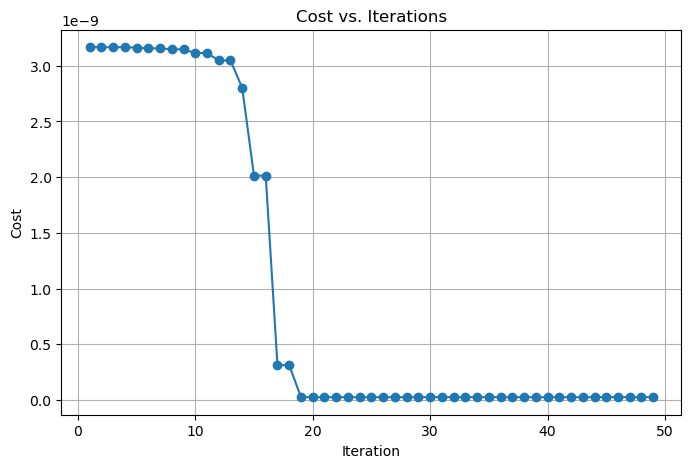

Optimization successful? False
Status code: 2
Message: Maximum number of iterations has been exceeded.
Number of iterations: 50
Final cost: 2.4999999999999555e-11
gamma    = 5.157e-45
gamma_R  = 3.077e+12
gamma_a  = 1.528e+16
gamma_v  = 2.314e+09
k_v      = 6.848e-09
flow     = 4.456e-20


In [21]:
import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt

def black_box_flow(gamma, gamma_R, gamma_a, gamma_v, k_v):
    fem_test = FEMSinkVelo.FEMSinkVelo(
        G=G,
        gamma=gamma,
        gamma_R=gamma_R,
        gamma_a=gamma_a,
        gamma_v=gamma_v,
        mu=1.0e-3,
        k_t=1.0e-10,
        k_v=k_v,
        P_in=100.0*133.322,
        p_cvp=1.0*133.322,
        Lambda_inlet=[0],
        Lambda_padding_min=0.008
    )
    flow_val = fem_test.compute_outflow_sink()
    return flow_val

def cost_function_log(params_log, target_flow):
    # Unpack parameters in log-space and convert to linear scale
    gamma_linear   = 10.0**(params_log[0])
    gamma_R_linear = 10.0**(params_log[1])
    gamma_a_linear = 10.0**(params_log[2])
    gamma_v_linear = 10.0**(params_log[3])
    k_v_linear     = 10.0**(params_log[4])

    # Evaluate the flow from the PDE solver
    flow_val = black_box_flow(
        gamma_linear,
        gamma_R_linear,
        gamma_a_linear,
        gamma_v_linear,
        k_v=k_v_linear
    )

    # Least-squares difference from the target flow
    return (flow_val - target_flow)**2

def multi_param_fit(
    target_flow=500.6,
    initial_guess_log=None,
    max_iter=50
):
    if initial_guess_log is None:
        initial_guess_log = [0.0, 0.0, 0.0, 0.0, -8.0]

    n_params = len(initial_guess_log)
    initial_simplex = [np.array(initial_guess_log)]
    for i in range(n_params):
        vertex = np.array(initial_guess_log, copy=True)
        if i == 4:  # k_v dimension: smaller step size
            vertex[i] += 0.01
        else:
            vertex[i] += 0.1
        initial_simplex.append(vertex)
    initial_simplex = np.array(initial_simplex)

    cost_history = []

    def callback(xk):
        cost = cost_function_log(xk, target_flow=target_flow)
        cost_history.append(cost)
        iteration_num = len(cost_history)
        print(f"Iteration {iteration_num}: parameters (log scale) = {xk}, cost = {cost}")

    result = minimize(
        fun=lambda p: cost_function_log(p, target_flow=target_flow),
        x0=np.array(initial_guess_log),
        method='Nelder-Mead',
        callback=callback,
        options={
            'maxiter': max_iter,
            'disp': True,
            'initial_simplex': initial_simplex
        }
    )

    best_log = result.x
    gamma_opt   = 10.0**(best_log[0])
    gammaR_opt  = 10.0**(best_log[1])
    gammaA_opt  = 10.0**(best_log[2])
    gammaV_opt  = 10.0**(best_log[3])
    k_v_opt     = 10.0**(best_log[4])

    flow_final = black_box_flow(gamma_opt, gammaR_opt, gammaA_opt, gammaV_opt, k_v_opt)

    # Plot the cost history
    plt.figure(figsize=(8, 5))
    plt.plot(range(1, len(cost_history) + 1), cost_history, marker='o', linestyle='-')
    plt.xlabel('Iteration')
    plt.ylabel('Cost')
    plt.title('Cost vs. Iterations')
    plt.grid(True)
    plt.show()

    return {
        'success': result.success,
        'status': result.status,
        'message': result.message,
        'n_iters': result.nit,
        'cost_final': result.fun,
        'gamma':   gamma_opt,
        'gamma_R': gammaR_opt,
        'gamma_a': gammaA_opt,
        'gamma_v': gammaV_opt,
        'k_v':     k_v_opt,
        'flow_final': flow_final,
        'cost_history': cost_history
    }

res = multi_param_fit(target_flow=5.0e-6, max_iter=50)

print("Optimization successful?", res['success'])
print("Status code:", res['status'])
print("Message:", res['message'])
print("Number of iterations:", res['n_iters'])
print("Final cost:", res['cost_final'])
print(f"gamma    = {res['gamma']:8.4g}")
print(f"gamma_R  = {res['gamma_R']:8.4g}")
print(f"gamma_a  = {res['gamma_a']:8.4g}")
print(f"gamma_v  = {res['gamma_v']:8.4g}")
print(f"k_v      = {res['k_v']:8.4g}")
print(f"flow     = {res['flow_final']:8.4g}")

In [ ]:
fem_test.save_vtk(os.path.join(WD_PATH, "perfusion_results", "25test3"))